# 概念介绍

## Setup

In [132]:
from PIL import Image
import numpy as np
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.models import Sequential
from keras.optimizers import Adam, Nadam, SGD
from keras.preprocessing import image
from keras.datasets import mnist
from keras.utils.np_utils import to_categorical
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, Activation
from keras.layers.normalization import BatchNormalization
from keras.callbacks import TensorBoard
from keras import backend as K
from skimage import exposure
from matplotlib import pyplot as plt, animation

%matplotlib inline
%precision 4
np.set_printoptions(precision=4, linewidth=100)

'%.4f'

打印narray的便利函数

In [4]:
def plots(ims, interp=False, titles=None):
    ims=np.array(ims)
    mn,mx=ims.min(),ims.max()
    f = plt.figure(figsize=(12,24))
    for i in range(len(ims)):
        sp=f.add_subplot(1, len(ims), i+1)
        if not titles is None: sp.set_title(titles[i], fontsize=18)
        plt.imshow(ims[i], interpolation=None if interp else 'none', vmin=mn,vmax=mx)

def plot(im, interp=False):
    f = plt.figure(figsize=(3,6), frameon=True)
    plt.imshow(im, interpolation=None if interp else 'none')

plt.gray()
plt.close()

## 导入训练样本

In [69]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

### 样本与标签

训练样本和测试样本的shape

In [12]:
(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

样本

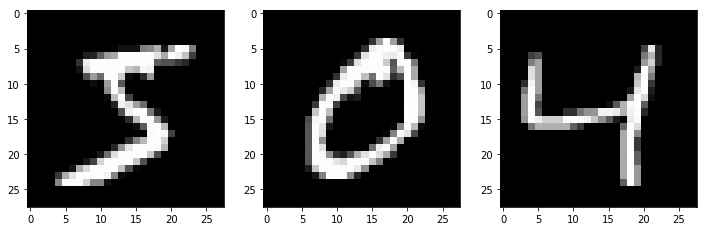

In [15]:
plots(x_train[:3])

标签

In [16]:
y_train[:3]

array([5, 0, 4], dtype=uint8)

样本在内存中的表示

In [11]:
x_train[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,  30,  36,  94, 154, 170, 253, 253, 253, 253, 253, 225, 172

## Convolution

简单的理解，卷积就是对图像特征的提取，有多少个卷积层就意味着提取了多少种特征，所以，如果你的训练样本非常复杂，就需要考虑增加卷积层，以提取足够的特征

输入

In [21]:
np.arange(9).reshape(3,3)

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

卷积核,卷积核中的数值就是我们需要计算的权重

In [23]:
np.arange(4).reshape(2,2)

array([[0, 1],
       [2, 3]])

手动卷积

In [24]:
[[0*0 + 1*1 + 2*3 + 3*4, 0*1 + 1*2 + 2*4 + 3*5],
 [0*3 + 1*4 + 2*6 + 3*7, 0*4 + 1*5 + 2*7 + 3*8]]

[[19, 25], [37, 43]]

## Dense

全连接层，最重要的应用在于改变输出的维度，例如，我的卷积层最后输出了3\*3的矩阵，但是我要做猫狗二分类，怎么办，就用一个Flatten层把输出1\*9的向量，然后再乘以9\*2的全连接矩阵，输出就是1\*2的向量，此时向量中的第一个分量大我们就可以认为是狗，反之则是猫

In [33]:
np.arange(3)

array([0, 1, 2])

这个矩阵中的值，就是我们需要训练的权重

In [34]:
np.arange(6).reshape(3,2)

array([[0, 1],
       [2, 3],
       [4, 5]])

In [36]:
[0*0 + 1*2 + 2*4, 0*1 + 1*3 + 2*5]

[10, 13]

## Maxpool

maxpool的作用是，使计算机能够获取更大范围的图像特征，即便是人类，如果每次只能查看9个像素的内容，也很难猜出当前图片是什么内容，所以需要通过maxpool降低图像特征提取的细节，提升图像特征提取范围

In [39]:
np.arange(16).reshape(4,4)

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11],
       [12, 13, 14, 15]])

In [45]:
[[np.max([0, 1, 4, 5]), np.max([2, 3, 6, 7])],
 [np.max([8, 9, 12, 13]), np.max([10, 11, 14, 15])]]

[[5, 7], [13, 15]]

## loss、Softmax、cross-entropy

* loss 即损失函数，标签与模型的输出的差异就是loss，在MNIST任务中，标签和模型输出都是10维向量，loss就是两个向量的差异，我们用交叉熵衡量这个差异。
* cross-entropy 不好理解，我们可以简单的理解为两个向量的方差，为什么不选平方差而选择交叉熵，下面是y=x*x的函数图，可以看到在接近0的位置也就是我们模型拟合最好的位置附近，导数非常接近0，如果此时采用梯度下降则会收敛的非常慢。交叉熵就是为了克服这个问题，交叉熵损失函数具有平方差一样的特性，非0，同时在0附近的梯度很陡峭。
* softmax 神经网络输出没办法告诉你结果是1还是0，只能告诉你1的概率是多少，0的概率是多少。直接用神经网路模型输出计算交叉熵时有个问题，数值得绝对大小并不能表示结果的概率大小，例如我们的标签是[1, 0] 模型的输出是[18,0],不说交叉熵，我们按平方差来算，也会认为我们的模型预测的非常不好，所以为了让输出的各个维度准确的表示概率，我们需要将结果先做softmax，softmax处理过后，向量的各个分类之和等于1，此时分量的大小可以准确的表达概率大小，就可以做交叉熵了。在预测结果的时候，我们会调用argmax获取概率最大的标签。

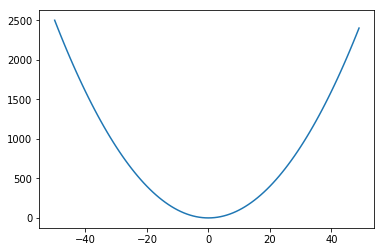

In [61]:
x = np.arange(100) - 50
y = x * x
plt.plot(x, y)

## 优化函数与梯度下降

优化函数就是根据loss的值不停地执行梯度下降算法，这里通过梯度下降求解一元一次方程，以说明梯度下降算法

假设，我们的目标函数为 ``y = 3 * x + 8``, 这里的 w=3 和 b=8 就是我之前反复提到的权重值, 机器学习需要训练数据，这里我们很容易自己创造

In [133]:
n = 30
x = np.random.rand(n)
y = 3 * x + 8
(x, y)

(array([ 0.0534,  0.7622,  0.3119,  0.6357,  0.6991,  0.7646,  0.6281,  0.1054,  0.7194,  0.8855,
         0.6838,  0.7633,  0.686 ,  0.4909,  0.5654,  0.8218,  0.1655,  0.8006,  0.4208,  0.9431,
         0.2059,  0.3713,  0.1471,  0.7298,  0.7608,  0.9217,  0.4288,  0.8768,  0.0984,  0.5249]),
 array([  8.1602,  10.2865,   8.9358,   9.9072,  10.0972,  10.2938,   9.8844,   8.3163,  10.1582,
         10.6565,  10.0515,  10.29  ,  10.058 ,   9.4726,   9.6962,  10.4655,   8.4966,  10.4017,
          9.2624,  10.8292,   8.6177,   9.1139,   8.4412,  10.1895,  10.2825,  10.7651,   9.2864,
         10.6305,   8.2952,   9.5747]))

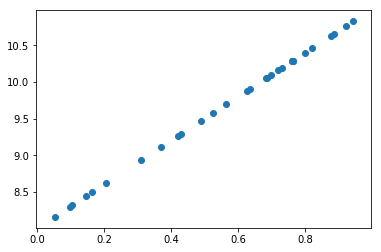

In [134]:
plt.scatter(x, y)

训练开始前，我们不知道 w = 3， b = 8，所以我们一般会给一个随机的初始值

In [244]:
w = 1
b = -1

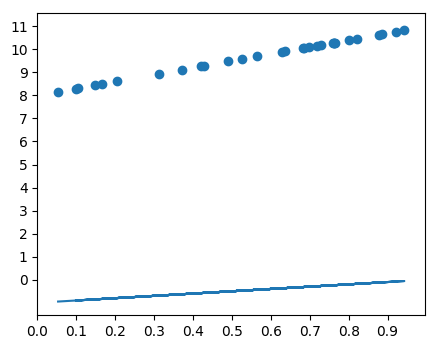

In [245]:
fig = plt.figure(dpi=100, figsize=(5, 4))
plt.xticks(np.arange(0, 1, 0.1))  
plt.yticks(np.arange(0, 15, 1)) 
plt.scatter(x,y)
plt.plot(x,lin(w, b, x));

交叉熵太复杂，loss用方差，所以相当于把每个``x``分别带入``3*x+8``与``10*x-1``然后求方差

In [137]:
def lin(w, b, x): return w*x+b
def sse(y,y_pred): return ((y-y_pred)**2).sum()
def loss(y,w,b,x): return sse(y, lin(w, b, x))
def avg_loss(y, w, b,x): return np.sqrt(loss(y, w, b,x) / n)

In [138]:
avg_loss(y, w, b, x)

10.1457

In [139]:
def upd():
    global w, b
    y_pred = lin(w, b, x)
    dydb = 2 * (y_pred - y)
    dyda = x*dydb
    w -= lr*dyda.mean()
    b -= lr*dydb.mean()

In [121]:
lr=0.01
# d[(y-(a*x+b))**2,b] = 2 (b + a x - y)      = 2 (y_pred - y)
# d[(y-(a*x+b))**2,a] = 2 x (b + a x - y)    = x * dy/db

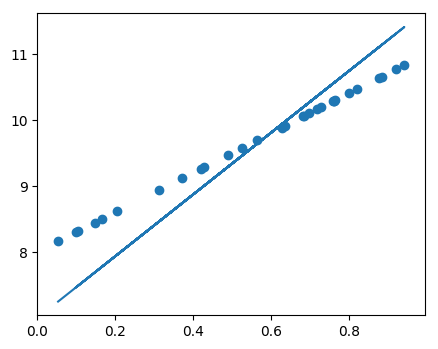

In [282]:
for _ in np.arange(10):
    upd()
fig = plt.figure(dpi=100, figsize=(5, 4))
plt.scatter(x,y)
plt.plot(x,lin(w, b, x));

## 验证灰度拉伸的有效性

In [73]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32')

In [72]:
(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

((60000, 28, 28, 1), (60000, 10), (10000, 28, 28, 1), (10000, 10))

In [ ]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [71]:
(y_train.shape, y_test.shape, y_train[0]

((60000, 10), (10000, 10))

array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.])

In [ ]:
mean_px = x_train.mean().astype(np.float32)
std_px = x_train.std().astype(np.float32)
def norm_input(x): return (x - mean_px) / std_px

In [74]:
def get_lin_model():
    model = Sequential([
        Flatten(input_shape = (28, 28, 1)),
        Dense(10, activation='softmax')
    ])
    model.compile(Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model
def get_lin_model_1():
    model = Sequential([
        Lambda(norm_input, input_shape = (28, 28, 1)),
        Flatten(),
        Dense(10, activation='softmax')
    ])
    model.compile(Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [75]:
batch_size = 64
gen = image.ImageDataGenerator(preprocessing_function=exposure.rescale_intensity)
batches = gen.flow(x_train, y_train, batch_size=batch_size)
test_batches = gen.flow(x_test, y_test, batch_size=batch_size)

In [76]:
lm = get_lin_model()
lm.fit_generator(batches, steps_per_epoch=batches.n//batch_size, epochs=1,
                 validation_data=test_batches, validation_steps=test_batches.n//batch_size)

Epoch 1/1
937/937 [==============================] - 8s 9ms/step - loss: 0.5453 - acc: 0.8605 - val_loss: 0.3321 - val_acc: 0.9113


## 打印model中间层输出

In [ ]:
model = get_lin_model()
np.set_printoptions(suppress=True, linewidth=240)
intermediate_tensor_function = K.function([model.layers[0].input],[model.layers[0].output])
intermediate_tensor = intermediate_tensor_function([x_train[1:2]])[0]
intermediate_tensor.reshape(28, 28).astype(int)

In [ ]:
intermediate_tensor_function = K.function([model.layers[0].input],[model.layers[1].output])
intermediate_tensor_function([x_train[1:2]])[0]

In [ ]:
np.array(model.get_weights()[0]).shape